Creating a Classification Model
==
**Authors**: Bao Dinh, Wesley Smith, Dakoda Fisher, Mohammed Qurneh, Andreas Cedron

**Research Question:** How do personal and occupational factors affect income?

**Dataset:** *Census Income* dataset extracted by Barry Becker in 1994 and donated to the [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)

**Problem Statement:** Using the *Census Income* dataset, predict whether the income of a U.S. individual will be greater than or less than $50,000 per year based on various personal and occupational factors.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/SP2024/DTSC-2302/class-project
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SP2024/DTSC-2302/class-project
 adult_dataset.csv     classification_model.ipynb   group5-barry-becker-classification-model.ipynb
 Adult_Dataset.ipynb   clean_adult_dataset.csv
'adult data.zip'       cleaning_dataset.ipynb


# Exploratory Data Analysis

## Importing Dataset

In [ ]:
import pandas as pd

df = pd.read_csv('adult_dataset.csv')
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
print(f"shape: {df.shape[0]} rows x {df.shape[1]} columns")

columns = []
for c in df.columns:
  columns.append(c)

print("columns:", columns)
print("target variable:", columns[-1])
print("predictor variable(s):", columns[0:14], '\n')

df.info()

shape: 48842 rows x 15 columns
columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
target variable: income
predictor variable(s): ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relatio

The dataset is 48,842 rows x 15 columns. The target variable is *income*. Most of the predictor variables are categorical; the continuous predictor variables are: *age*, *capital-gain*, *capital-loss*, and *hours-per-week*.

## Checking Column Values

### Checking Null Values

In [ ]:
df.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

There are null values in the columns *workclass*, *occupation*, and *native-country*. We may have to drop the rows with null values as they can negatively impact the performance of our model.

### Checking Unique Values

In [ ]:
columns_unique_values = {
    columns[0]: df[columns[0]].sort_values().unique(),
    columns[1]: df[columns[1]].sort_values().unique(),
    columns[2]: df[columns[2]].sort_values().unique(),
    columns[3]: df[columns[3]].sort_values().unique(),
    columns[4]: df[columns[4]].sort_values().unique(),
    columns[5]: df[columns[5]].sort_values().unique(),
    columns[6]: df[columns[6]].sort_values().unique(),
    columns[7]: df[columns[7]].sort_values().unique(),
    columns[8]: df[columns[8]].sort_values().unique(),
    columns[9]: df[columns[9]].sort_values().unique(),
    columns[10]: df[columns[10]].sort_values().unique(),
    columns[11]: df[columns[11]].sort_values().unique(),
    columns[12]: df[columns[12]].sort_values().unique(),
    columns[13]: df[columns[13]].sort_values().unique(),
    columns[14]: df[columns[14]].sort_values().unique()
}

for key, values in columns_unique_values.items():
  print(key + ':', values, '\n')

age: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 89 90] 

workclass: ['?' 'Federal-gov' 'Local-gov' 'Never-worked' 'Private' 'Self-emp-inc'
 'Self-emp-not-inc' 'State-gov' 'Without-pay' nan] 

fnlwgt: [  12285   13492   13769 ... 1455435 1484705 1490400] 

education: ['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college'] 

education-num: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] 

marital-status: ['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed'] 

occupation: ['?' 'Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-s

Our target variable, *income*, is currently not a binary variable; we will have to transform it into a binary variable for our classification model.

The columns *workclass*, *occupation*, and *native-country* have the invalid value '?'; we will have to transform the '?' values into null values.

The columns *capital-gain* and *hours-per-week* seem to have a maximum values: $99,999 and 99 hours, respectively.

## Cleaning Dataset

### Making *income* Binary

In [ ]:
foo = df.copy()

foo.loc[foo['income'] == '<=50K.', 'income'] = '<=50K'
foo.loc[foo['income'] == '>50K.', 'income'] = '>50K'

foo['income'].unique()

array(['<=50K', '>50K'], dtype=object)

### Making '?' Values Into Null Values

In [ ]:
bar = foo.copy()

bar.loc[bar['workclass'] == '?', 'workclass'] = None
bar.loc[bar['occupation'] == '?', 'occupation'] = None
bar.loc[bar['native-country'] == '?', 'native-country'] = None

bar.loc[bar['workclass'].isnull(), 'workclass'] = None
bar.loc[bar['occupation'].isnull(), 'occupation'] = None
bar.loc[bar['native-country'].isnull(), 'native-country'] = None

bar.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

### Dropping Null Rows

In [ ]:
foobar = bar.copy()

foobar[foobar['workclass'] == 'Never-worked']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5361,18,Never-worked,206359,10th,6,Never-married,None,Own-child,White,Male,0,0,40,United-States,<=50K
10845,23,Never-worked,188535,7th-8th,4,Divorced,None,Not-in-family,White,Male,0,0,35,United-States,<=50K
14772,17,Never-worked,237272,10th,6,Never-married,None,Own-child,White,Male,0,0,30,United-States,<=50K
20337,18,Never-worked,157131,11th,7,Never-married,None,Own-child,White,Female,0,0,10,United-States,<=50K
23232,20,Never-worked,462294,Some-college,10,Never-married,None,Own-child,Black,Male,0,0,40,United-States,<=50K
32304,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,None,Wife,Black,Female,0,0,40,United-States,<=50K
32314,18,Never-worked,153663,Some-college,10,Never-married,None,Own-child,White,Male,0,0,4,United-States,<=50K
41346,17,Never-worked,131593,11th,7,Never-married,None,Own-child,Black,Female,0,0,20,United-States,<=50K
44168,20,Never-worked,273905,HS-grad,9,Married-spouse-absent,None,Other-relative,White,Male,0,0,35,United-States,<=50K
46459,18,Never-worked,162908,11th,7,Never-married,None,Own-child,White,Male,0,0,35,United-States,<=50K


In [ ]:
foobar[(foobar['workclass'].isnull() == False) & (foobar['occupation'].isnull() == True)]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5361,18,Never-worked,206359,10th,6,Never-married,None,Own-child,White,Male,0,0,40,United-States,<=50K
10845,23,Never-worked,188535,7th-8th,4,Divorced,None,Not-in-family,White,Male,0,0,35,United-States,<=50K
14772,17,Never-worked,237272,10th,6,Never-married,None,Own-child,White,Male,0,0,30,United-States,<=50K
20337,18,Never-worked,157131,11th,7,Never-married,None,Own-child,White,Female,0,0,10,United-States,<=50K
23232,20,Never-worked,462294,Some-college,10,Never-married,None,Own-child,Black,Male,0,0,40,United-States,<=50K
32304,30,Never-worked,176673,HS-grad,9,Married-civ-spouse,None,Wife,Black,Female,0,0,40,United-States,<=50K
32314,18,Never-worked,153663,Some-college,10,Never-married,None,Own-child,White,Male,0,0,4,United-States,<=50K
41346,17,Never-worked,131593,11th,7,Never-married,None,Own-child,Black,Female,0,0,20,United-States,<=50K
44168,20,Never-worked,273905,HS-grad,9,Married-spouse-absent,None,Other-relative,White,Male,0,0,35,United-States,<=50K
46459,18,Never-worked,162908,11th,7,Never-married,None,Own-child,White,Male,0,0,35,United-States,<=50K


In [ ]:
foobar[(foobar['workclass'].isnull() == True) & (foobar['occupation'].isnull() == False)]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


The rows where *occupation* is equal to 'null' but *workclass* isn't corresponds to the rows where *workclass* is equal to 'Never-worked'. In addition, the rows where *workclass* is equal to 'Never-worked' has values in 'hour-per-week' greater than 0. Due to the null values and the contradictory values, we will drop these rows.

There are no rows where *workclass* is equal to 'null' but *occupation* is equal to a non-null value; thus, dropping the null rows of *occupation* will also drop all of the null rows of *workclass*.

In [ ]:
foobar = foobar[foobar['occupation'].isnull() == False]
foobar = foobar[foobar['native-country'].isnull() == False]

print(f"shape: {foobar.shape[0]} rows x {foobar.shape[1]} columns")
foobar.isnull().sum()

shape: 45222 rows x 15 columns


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

Dropping the rows with null values reduced our dataset by 7%, from 48842 rows to 45222 rows; 45222 entries leaves us with a large enough sample to create a classification model. By dropping the rows with null values, we don't have to worry about null values negatively impacting our model's performance.

### Dropping Columns

*education-num* is the result of ordinally-encoding *education*; however, we must check the column was properly encoded before we can drop *education*. We want to drop *education* because we want to avoid multicollinearity.

In [ ]:
baz = foobar.copy()

for i in range(1, 17):
  print(baz['education'][baz['education-num'] == i].unique())

['Preschool']
['1st-4th']
['5th-6th']
['7th-8th']
['9th']
['10th']
['11th']
['12th']
['HS-grad']
['Some-college']
['Assoc-voc']
['Assoc-acdm']
['Bachelors']
['Masters']
['Prof-school']
['Doctorate']


The output shows that each ascending value in *education-num* uniquely encodes the appropriate value in *education*; thus, *education* was properly, ordinally-encoded by *education-num* and *education* can be dropped.

In [ ]:
baz = baz.drop('education', axis=1)
baz

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,Private,245211,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K
48837,39,Private,215419,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48839,38,Private,374983,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


### Combining Columns

In [ ]:
qux = baz.copy()

qux[(qux['capital-gain'] > 0) & (qux['capital-loss'] > 0)]

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


The columns *capital-gain* and *capital-loss* are mutually exclusive (i.e. if *capital-gain* is greater than 0, then *capital-loss* is equal to 0, and vice versa); thus, we should combine the columns to avoid multicollinearity as they describe the same concept --- profits (or losses) selling a capital asset.

In [ ]:
qux['capital-loss'] = qux['capital-loss'] * -1
qux[qux['capital-loss'] != 0]

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
23,43,Private,117037,7,Married-civ-spouse,Transport-moving,Husband,White,Male,0,-2042,40,United-States,<=50K
32,45,Private,386940,13,Divorced,Exec-managerial,Own-child,White,Male,0,-1408,40,United-States,<=50K
52,47,Private,51835,15,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,-1902,60,Honduras,>50K
96,48,Self-emp-not-inc,191277,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,-1902,60,United-States,>50K
112,56,Self-emp-not-inc,335605,9,Married-civ-spouse,Other-service,Husband,White,Male,0,-1887,50,Canada,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48783,19,Private,156618,9,Never-married,Other-service,Own-child,White,Female,0,-1602,20,United-States,<=50K
48794,29,Local-gov,170482,9,Married-civ-spouse,Protective-serv,Husband,Black,Male,0,-2057,40,United-States,<=50K
48802,51,Private,29887,13,Divorced,Tech-support,Not-in-family,White,Male,0,-1590,40,United-States,<=50K
48814,39,Private,229647,13,Never-married,Tech-support,Not-in-family,White,Female,0,-1669,40,United-States,<=50K


In [ ]:
qux['capital-gain'] = qux['capital-gain'] + qux['capital-loss']
qux = qux.drop(['capital-loss'], axis=1)

In [ ]:
qux[qux['capital-gain'] < 0]

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,hours-per-week,native-country,income
23,43,Private,117037,7,Married-civ-spouse,Transport-moving,Husband,White,Male,-2042,40,United-States,<=50K
32,45,Private,386940,13,Divorced,Exec-managerial,Own-child,White,Male,-1408,40,United-States,<=50K
52,47,Private,51835,15,Married-civ-spouse,Prof-specialty,Wife,White,Female,-1902,60,Honduras,>50K
96,48,Self-emp-not-inc,191277,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,-1902,60,United-States,>50K
112,56,Self-emp-not-inc,335605,9,Married-civ-spouse,Other-service,Husband,White,Male,-1887,50,Canada,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48783,19,Private,156618,9,Never-married,Other-service,Own-child,White,Female,-1602,20,United-States,<=50K
48794,29,Local-gov,170482,9,Married-civ-spouse,Protective-serv,Husband,Black,Male,-2057,40,United-States,<=50K
48802,51,Private,29887,13,Divorced,Tech-support,Not-in-family,White,Male,-1590,40,United-States,<=50K
48814,39,Private,229647,13,Never-married,Tech-support,Not-in-family,White,Female,-1669,40,United-States,<=50K


# Data Preprocessing

## Summary Statistics

In [ ]:
qux.describe()

,age,fnlwgt,education-num,capital-gain,hours-per-week
count,45222.000000,4.522200e+04,45222.000000,45222.000000,45222.000000
mean,38.547941,1.897347e+05,10.118460,1012.834925,40.938017
std,13.217870,1.056392e+05,2.552881,7530.315380,12.007508
min,17.000000,1.349200e+04,1.000000,-4356.000000,1.000000
25%,28.000000,1.173882e+05,9.000000,0.000000,40.000000
50%,37.000000,1.783160e+05,10.000000,0.000000,40.000000
75%,47.000000,2.379260e+05,13.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,99.000000


## Variable Distribution

### Distribution of *age*

Text(0.5, 1.0, 'Distribution of Age')

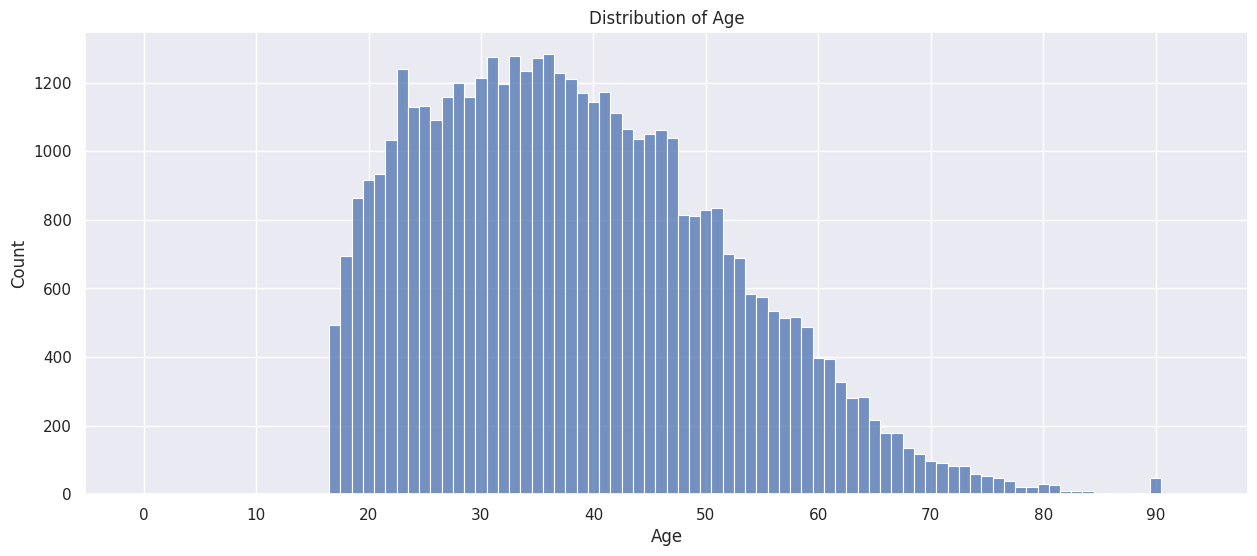

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style='darkgrid')

plt.figure(figsize=(15, 6))
sns.histplot(data=qux['age'], bins=np.arange(95)-0.5)

plt.xticks(range(0, 100, 10))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')

Text(0.5, 1.0, 'Distribution of Age vs. Income Level')

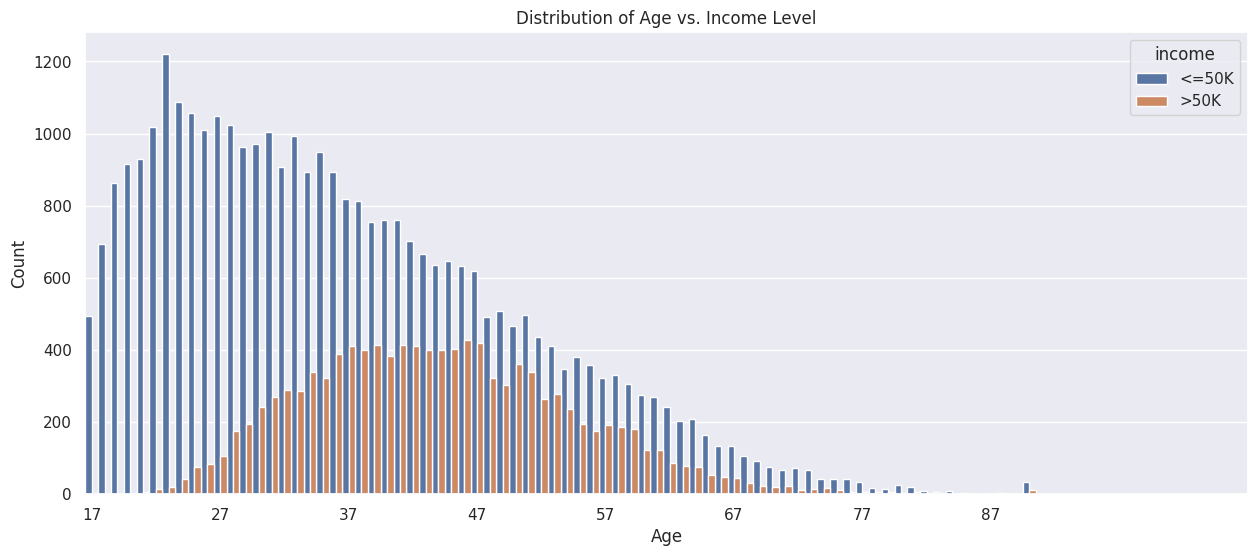

In [ ]:
data = qux[['age', 'income']]

plt.figure(figsize=(15, 6))
sns.countplot(data=data, x='age', hue='income', width=1)

plt.xticks(range(0, 100, 10))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age vs. Income Level')

### Distribution of *workclass*

Text(0.5, 1.0, 'Distribution of Work Class vs. Income')

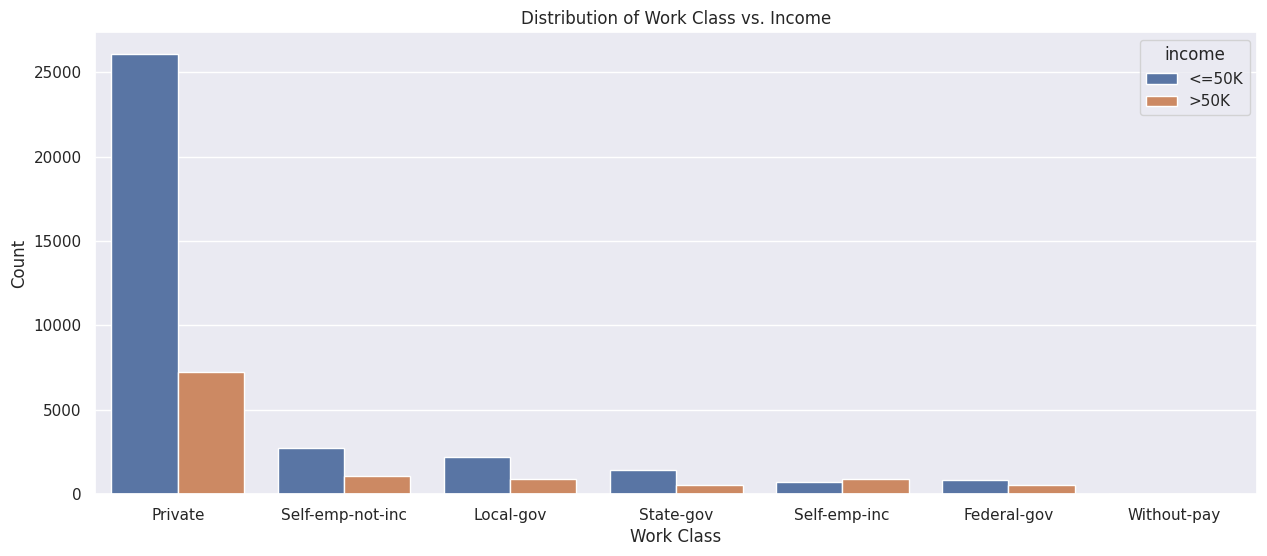

In [ ]:
data = qux[['workclass', 'income']]

plt.figure(figsize=(15, 6))
sns.countplot(data=data, x='workclass', hue='income', order=data['workclass'].value_counts().index)


plt.xlabel('Work Class')
plt.ylabel('Count')
plt.title('Distribution of Work Class vs. Income')

### Distribution of *education*

Text(0.5, 1.0, 'Distribution of Highest Education Level vs. Income')

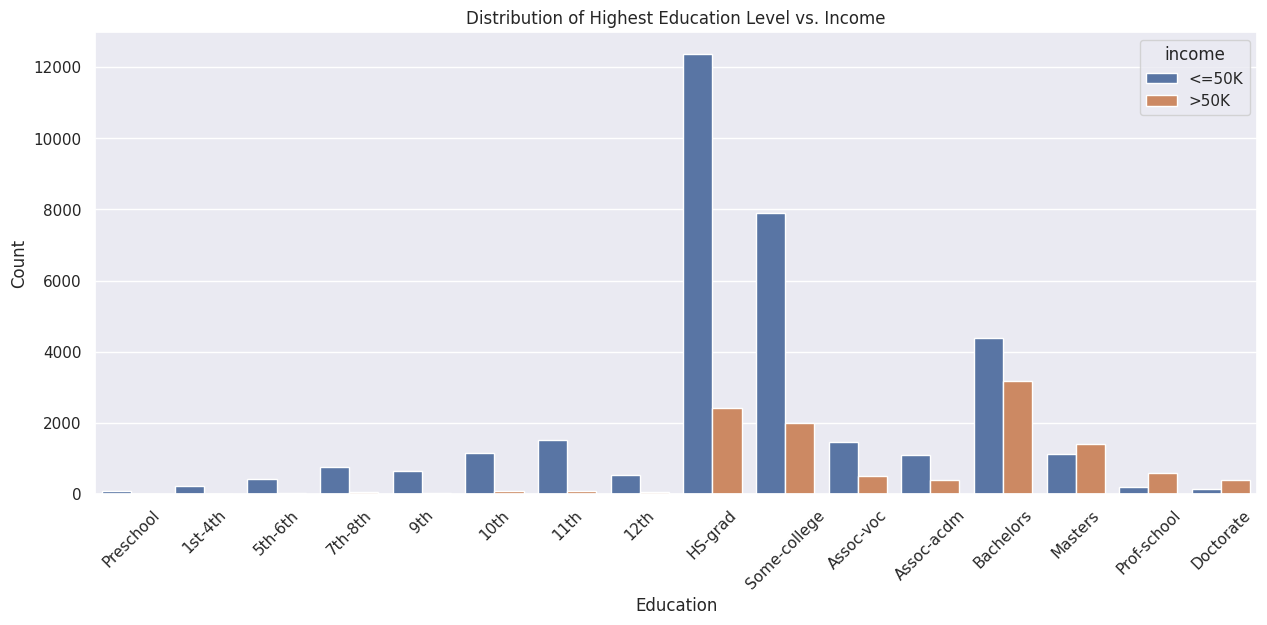

In [ ]:
data = foobar[['education', 'education-num', 'income']].sort_values('education-num')

plt.figure(figsize=(15, 6))
sns.countplot(data=data, x='education', hue='income')


plt.xlabel('Education')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Distribution of Highest Education Level vs. Income')

### Distribution of *marital-status*

Text(0.5, 1.0, 'Distribution of Marital Status vs. Income')

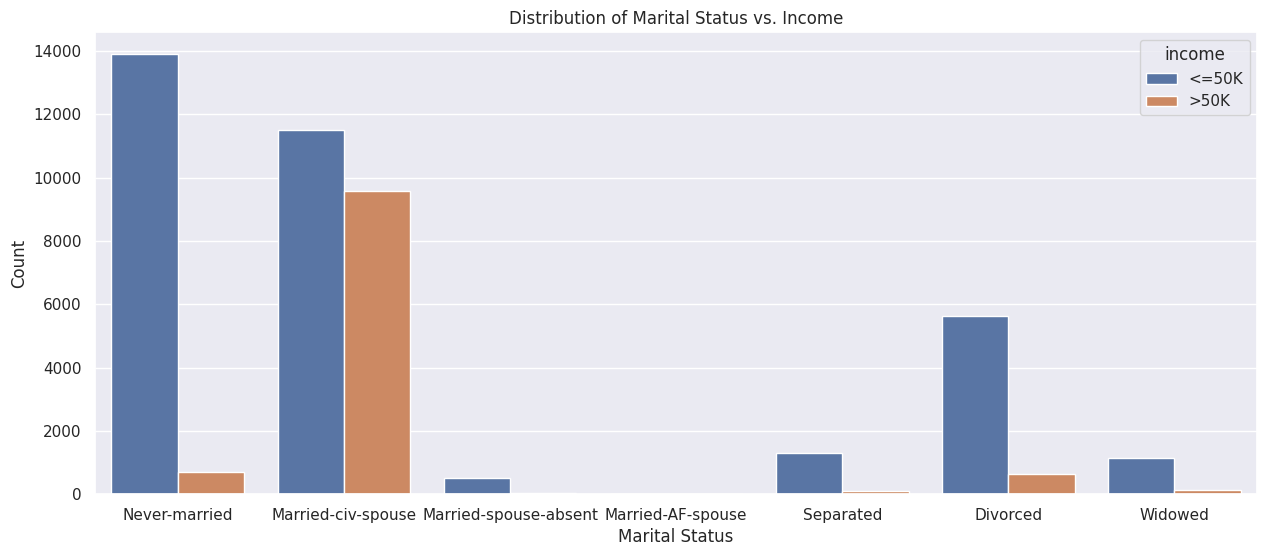

In [ ]:
data = qux[['marital-status', 'income']]
order = ['Never-married', 'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse', 'Separated', 'Divorced', 'Widowed']

plt.figure(figsize=(15, 6))
sns.countplot(data=data, x='marital-status', hue='income', order=order)


plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Distribution of Marital Status vs. Income')

### Distribution of *occupation*

Text(0.5, 1.0, 'Distribution of Occupation vs. Income')

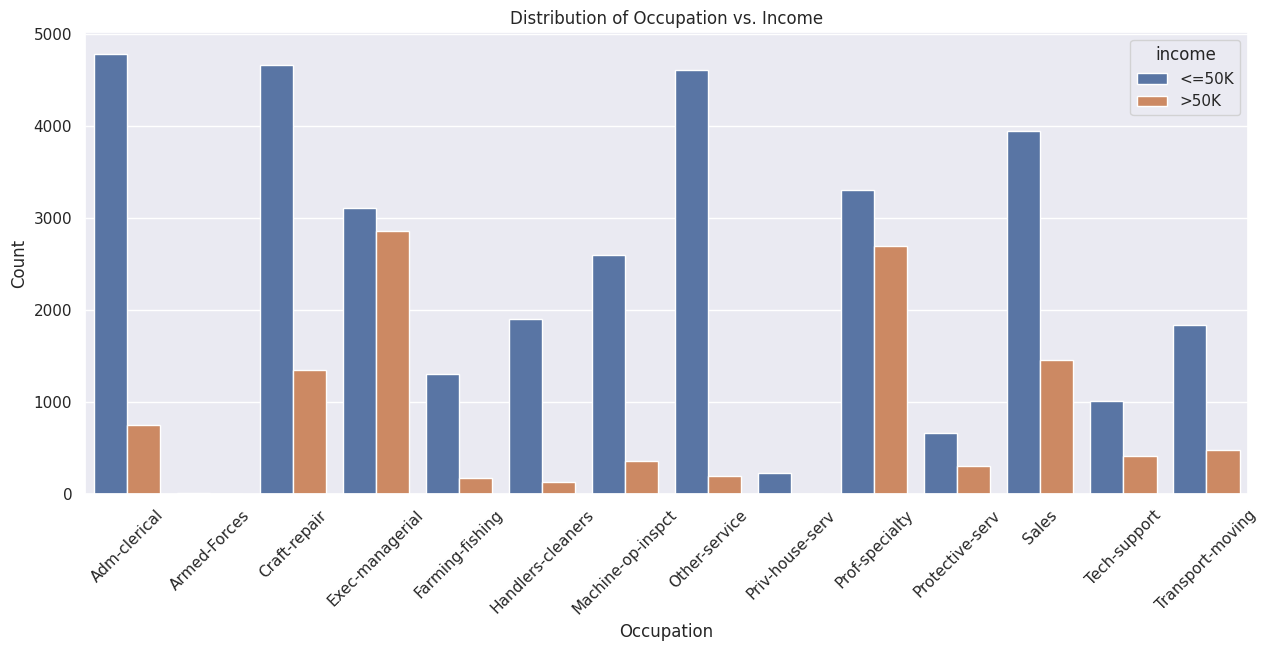

In [ ]:
data = qux[['occupation', 'income']]
order = data['occupation'].unique()
order.sort()

plt.figure(figsize=(15, 6))
sns.countplot(data=data, x='occupation', hue='income', order=order)


plt.xlabel('Occupation')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Distribution of Occupation vs. Income')

### Distribution of *relationship*

Text(0.5, 1.0, 'Distribution of Relationship Status vs. Income')

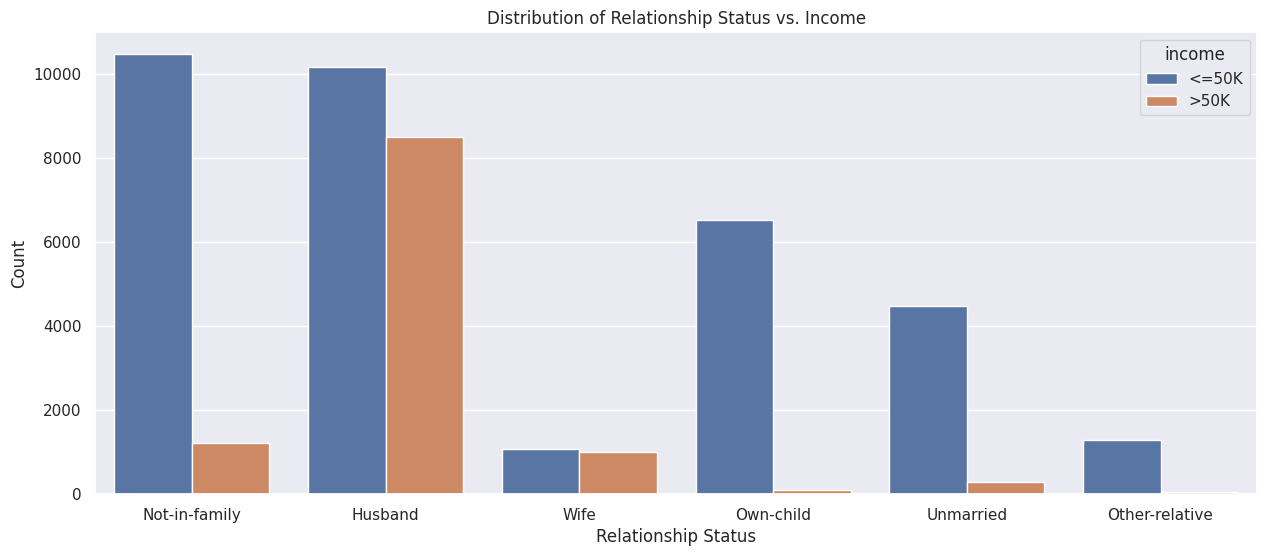

In [ ]:
data = qux[['relationship', 'income']]

plt.figure(figsize=(15, 6))
sns.countplot(data=data, x='relationship', hue='income')


plt.xlabel('Relationship Status')
plt.ylabel('Count')
plt.title('Distribution of Relationship Status vs. Income')

### Distribution of *race*

Text(0.5, 1.0, 'Distribution of Race vs. Income')

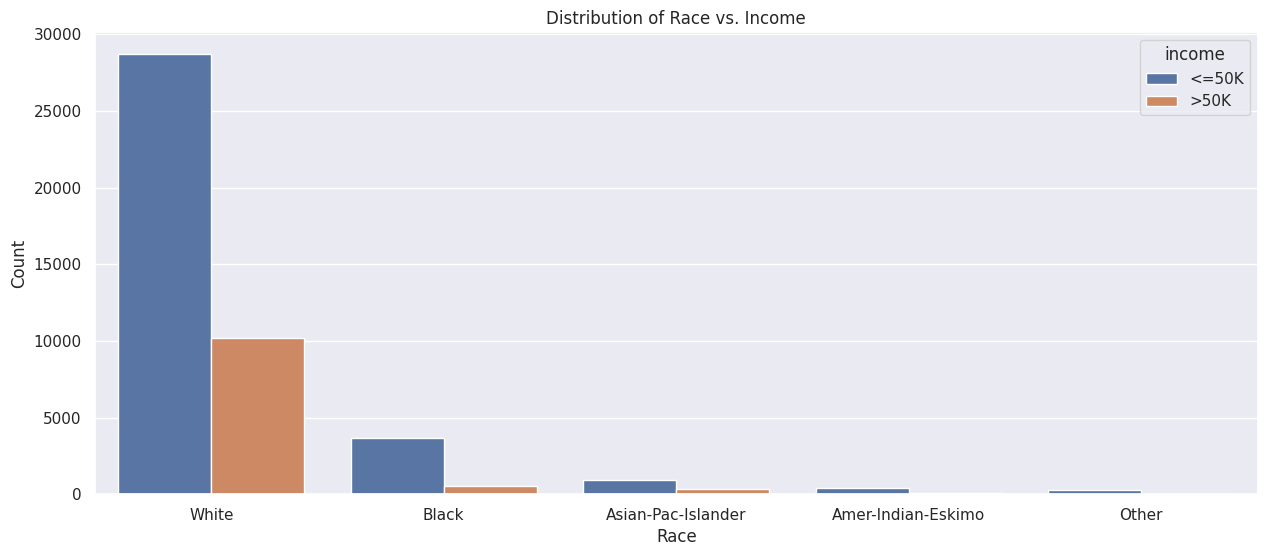

In [ ]:
data = qux[['race', 'income']]

plt.figure(figsize=(15, 6))
sns.countplot(data=data, x='race', hue='income')


plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of Race vs. Income')

### Distribution of *sex*

Text(0.5, 1.0, 'Distribution of Sex vs. Income')

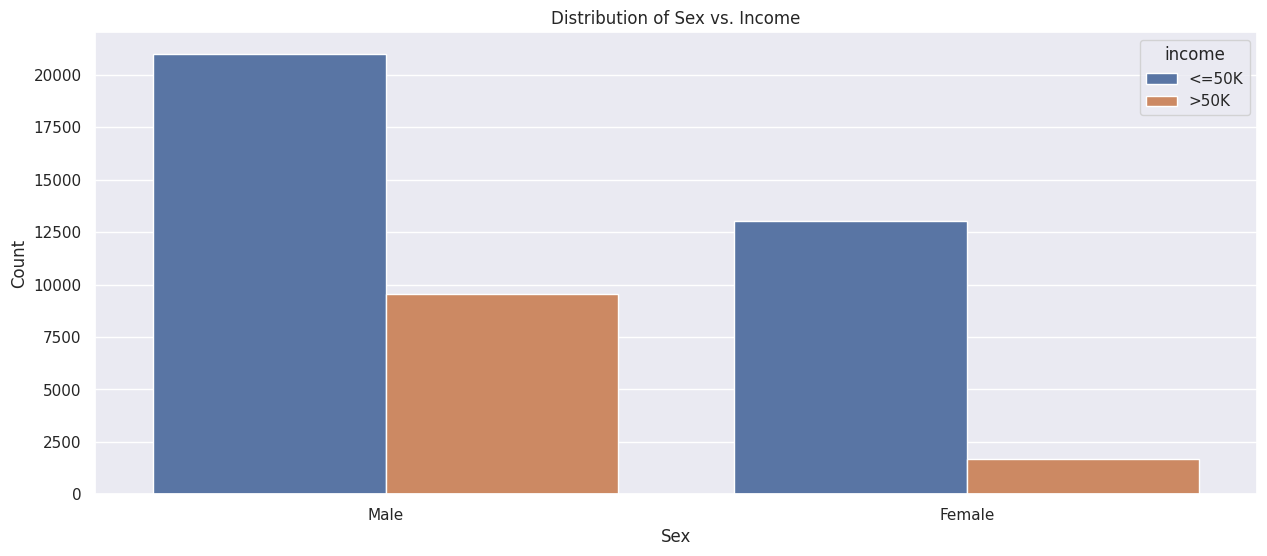

In [ ]:
data = qux[['sex', 'income']]

plt.figure(figsize=(15, 6))
sns.countplot(data=data, x='sex', hue='income')


plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Sex vs. Income')

Text(0.5, 1.0, 'Distribution of Capital Gains vs. Income')

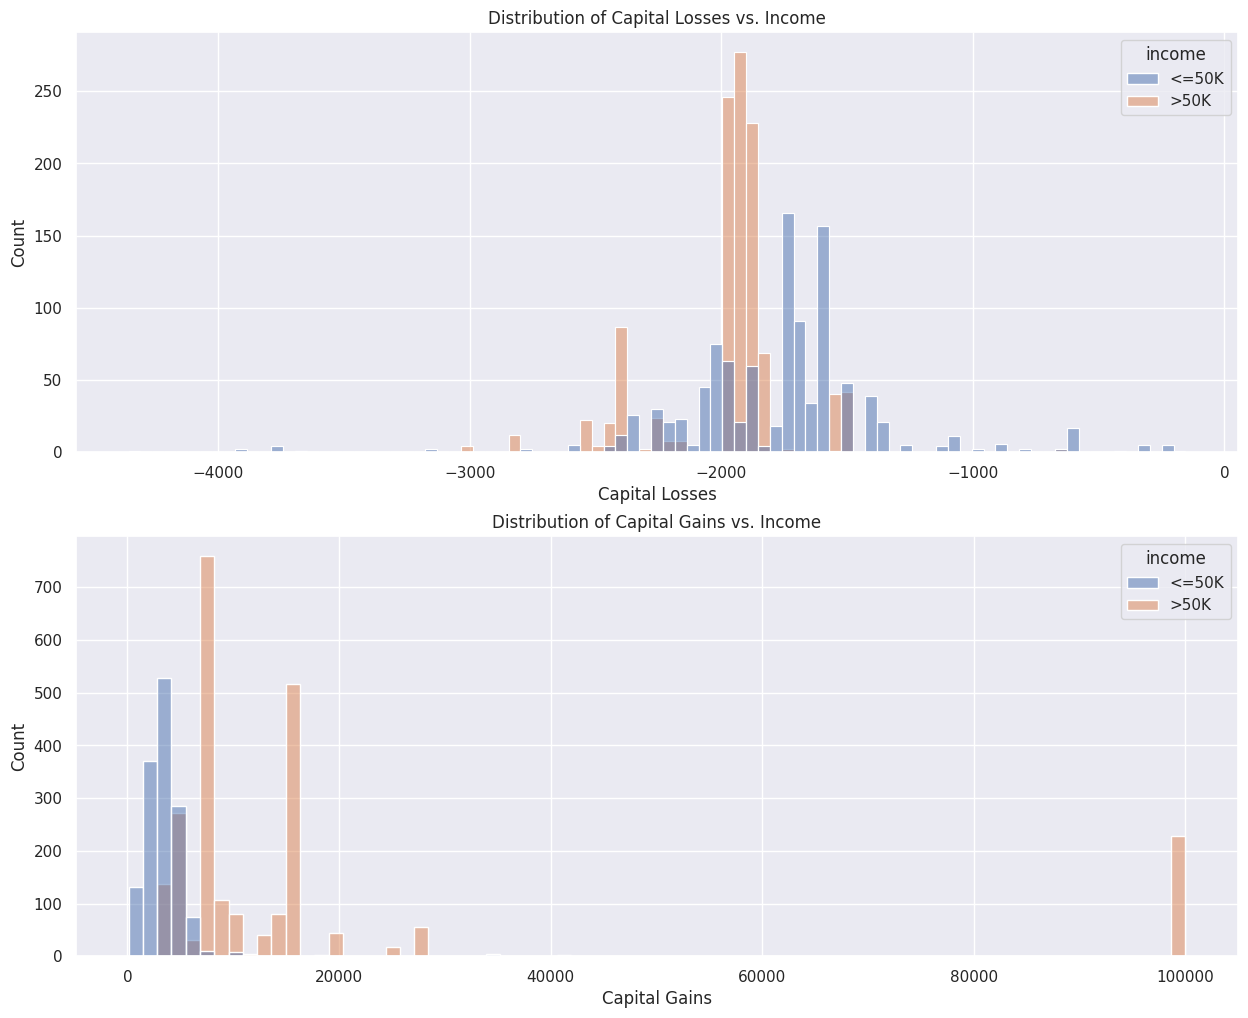

In [ ]:
data = qux[['capital-gain', 'income']]
capital_loss = data[data['capital-gain'] < 0]
capital_gain = data[data['capital-gain'] > 0]

plt.figure(figsize=(15, 12))

plt.subplot(2, 1, 1)
sns.histplot(data=capital_loss, x='capital-gain', hue='income')

plt.xlabel('Capital Losses')
plt.ylabel('Count')
plt.title('Distribution of Capital Losses vs. Income')

plt.subplot(2, 1, 2)
sns.histplot(data=capital_gain, x='capital-gain', hue='income')

plt.xlabel('Capital Gains')
plt.ylabel('Count')
plt.title('Distribution of Capital Gains vs. Income')

### Distribution of *hours-per-week*

Text(0.5, 1.0, 'Distribution of Hours Per Week vs. Income Level')

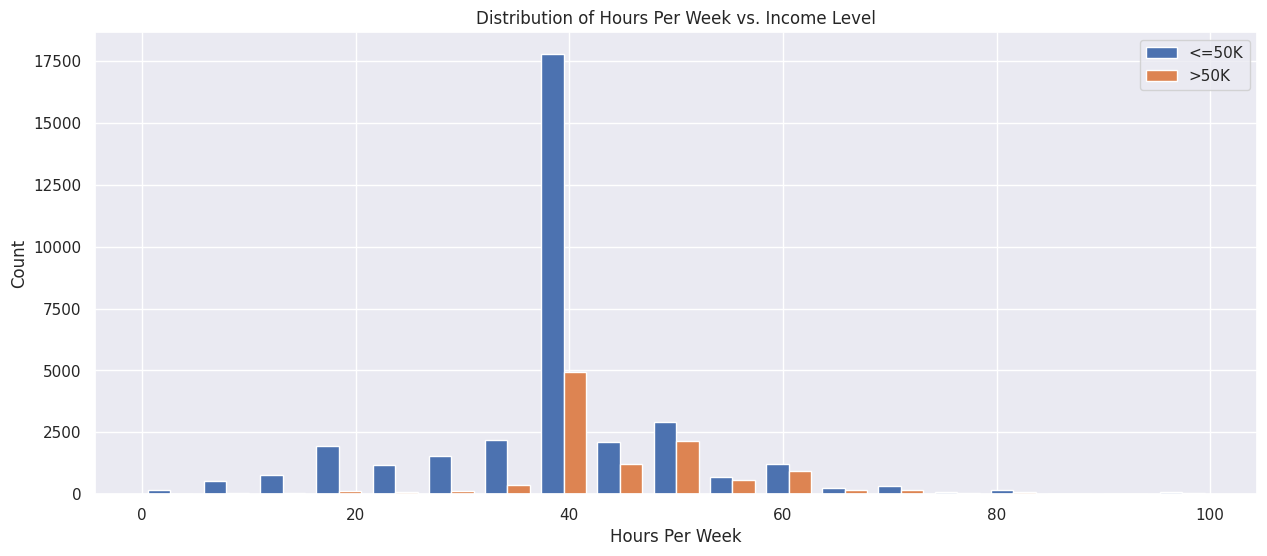

In [ ]:
data = qux[['hours-per-week', 'income']]
below_income = data[data['income'] == '<=50K']['hours-per-week']
above_income = data[data['income'] == '>50K']['hours-per-week']

plt.figure(figsize=(15, 6))
plt.hist(x=[below_income, above_income], bins=np.linspace(0, 100, 20), label=['<=50K', '>50K'])

plt.legend(loc='upper right')
plt.xlabel('Hours Per Week')
plt.ylabel('Count')
plt.title('Distribution of Hours Per Week vs. Income Level')

### Distribution of *native-country*

Text(0.5, 1.0, 'Distribution of Native Country vs. Income')

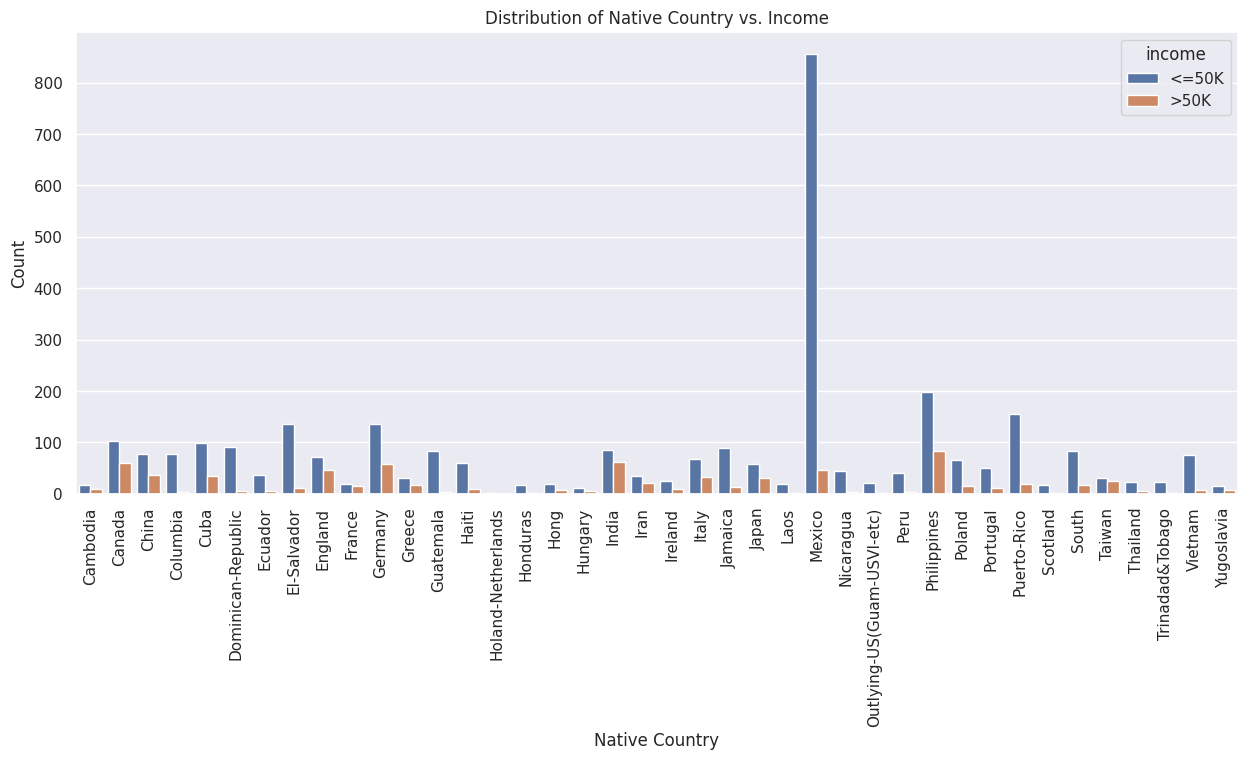

In [ ]:
data = qux[['native-country', 'income']]
data = data[data['native-country'] != 'United-States']
order = data['native-country'].unique()
order.sort()

plt.figure(figsize=(15, 6))
sns.countplot(data=data, x='native-country', hue='income', order=order)


plt.xlabel('Native Country')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Distribution of Native Country vs. Income')

## Correlation Analysis

### Ordinally-Encoding Variables

In [ ]:
from sklearn.preprocessing import LabelEncoder

waldo = qux.copy()

label_encoder = LabelEncoder()
waldo['workclass'] = label_encoder.fit_transform(waldo['workclass'])
waldo['marital-status'] = label_encoder.fit_transform(waldo['marital-status'])
waldo['occupation'] = label_encoder.fit_transform(waldo['occupation'])
waldo['relationship'] = label_encoder.fit_transform(waldo['relationship'])
waldo['race'] = label_encoder.fit_transform(waldo['race'])
waldo['sex'] = label_encoder.fit_transform(waldo['sex'])
waldo['native-country'] = label_encoder.fit_transform(waldo['native-country'])

waldo

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,hours-per-week,native-country,income
0,39,5,77516,13,4,0,1,4,1,2174,40,38,<=50K
1,50,4,83311,13,2,3,0,4,1,0,13,38,<=50K
2,38,2,215646,9,0,5,1,4,1,0,40,38,<=50K
3,53,2,234721,7,2,5,0,2,1,0,40,38,<=50K
4,28,2,338409,13,2,9,5,2,0,0,40,4,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,2,245211,13,4,9,3,4,1,0,40,38,<=50K
48837,39,2,215419,13,0,9,1,4,0,0,36,38,<=50K
48839,38,2,374983,13,2,9,0,4,1,0,50,38,<=50K
48840,44,2,83891,13,0,0,3,1,1,5455,40,38,<=50K


### Calculate VIF Scores

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = waldo.loc[:, list(waldo.columns)[0:12]]

vif_scores = pd.DataFrame()
vif_scores["Attribute"] = X.columns

vif_scores["VIF Scores"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

display(vif_scores)

,Attribute,VIF Scores
0,age,9.348787
1,workclass,6.236286
2,fnlwgt,4.033802
3,education-num,16.138177
4,marital-status,4.012031
5,occupation,3.201028
6,relationship,2.606876
7,race,18.489588
8,sex,4.559578
9,capital-gain,1.038207
